In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def generate_synth_dataset(p: float, n: int, d: int, g: float)->pd.DataFrame:
    """Generating a synthetic dataset
    Args:
        p (float): class prior probability
        n (int): number of observations
        d (int): number of features (dimensions)
        g (float): correlation between features
    Returns:
        Datadrame: dataset with d features, n rows
    """
    Y = np.random.binomial(1, p, size=n)
    S = np.array([[g ** abs(i - j) for j in range(d)] for i in range(d)])
    
    mean_0 = np.zeros(d)
    mean_1 = np.array([1/(i+1) for i in range(d)])
    
    X = np.array([
        multivariate_normal.rvs(mean=mean_1 if y == 1 else mean_0, cov=S)
        for y in Y
    ])
    
    feature_names = [f'f{i+1}' for i in range(d)]
    dataset = pd.DataFrame(X, columns=feature_names)
    dataset['Y'] = Y
    
    return dataset


In [2]:
from sklearn.linear_model import LogisticRegression

ban = LogisticRegression()

In [3]:
p = 0.5   # probability of class = 1
n = 200   # number of observations
d = 10    # number of features
g = 0.5   # correlation between features

dataset = generate_synth_dataset(p, n, d, g)
print(dataset.head())

         f1        f2        f3        f4        f5        f6        f7  \
0  2.231829  1.068855  1.496974  1.118139  0.782413  1.935923  2.138145   
1 -0.999255  0.121316  0.821500 -1.235753 -1.808677 -1.993101 -1.937840   
2  0.928667  0.786716  0.782887 -0.310454  0.522290  0.989727 -1.238812   
3 -1.147037 -0.736952 -1.674647  0.280216 -0.285644 -0.481291  0.580669   
4 -2.065920 -2.070863 -0.931213  1.403410  1.125943  1.146452  1.187365   

         f8        f9       f10  Y  
0  1.922238 -0.033994 -0.386682  1  
1 -1.373024 -2.193035 -2.123571  0  
2 -0.064416 -0.260550 -2.084328  1  
3  1.111330  2.224104  0.828024  0  
4  1.377545  0.357252  1.122802  0  


In [4]:
from sklearn.model_selection import train_test_split

feature_cols =['f1','f2','f3','f4','f5','f6','f7','f8', 'f9','f10']
y = dataset.Y
X = dataset[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


In [5]:
β = np.zeros(X_train.shape[1])
xi = X_train.iloc[0].values
print(xi)
print(β)
np.dot(xi, β)


[ 2.92708721  2.54844387  1.26788552  0.05941619 -1.08873204 -0.85086814
 -0.77753969  0.08241342 -1.69586446 -0.23268599]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


0.0

In [6]:
np.array(y_train)

array([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0])

In [7]:
from sklearn.metrics import roc_auc_score, average_precision_score, recall_score, precision_score, f1_score, balanced_accuracy_score

class LogRegCCD:
    def __init__(self, lambdas):
        self.lambdas = lambdas
        self.coef_path_ = []
        self.intercept_path_ = []
        self.best_lambda_ = None
        self.best_coef_ = None
        self.best_intercept_ = None

    def fit(self, X_train, y_train, is_update_weighted, alpha=1.0, tol=1e-8, max_iter=100):
        """Train logistic regression with CCD"""
        X = np.array(X_train)
        y = np.array(y_train)
        N, d = X.shape
        
        for l in self.lambdas:  # Iterate through each lambda
            b = np.zeros(d)  # Initialize weights to zero
            b_0 = 0  # Initialize bias (intercept)
            
            for iteration in range(max_iter):
                b_old = b.copy()
                b0_old = b_0
                
                # Compute probability predictions
                linear_comb = b_0 + X @ b
                p = 1 / (1 + np.exp(-linear_comb))  # Sigmoid function
                w = p * (1 - p)                
                # Update each coordinate j independently
                for j in range(d):
                    X_j = X[:, j]  # Extract feature column
                    # numerator = np.sum(X_j * (y - p))  # ∑ x_ij (y_i - p_i)
                    # denominator = np.sum(X_j**2)  # ∑ x_ij^2
                    if not is_update_weighted:
                        numerator = np.mean(X_j * (y - p))  # Equivalent to 1/N sum
                        denominator = 1 + l * (1 - alpha) # Penalty and denom
                    else:
                        numerator = np.sum(w * X_j * (y - p)) # ∑ w_i x_ij (y_i - p_i)
                        denominator = np.sum(w * X_j**2) + l * (1 - alpha) 
                        
                    denominator = max(denominator, 1e-10)  # Prevent division by zero
                    b[j] = self.soft_threshold(numerator, l * alpha) / denominator

                b_0 = np.mean(y - p)
                
                if np.max(np.abs(b - b_old)) < tol and np.abs(b_0 - b0_old) < tol:
                    break

            # Store the solution path
            self.coef_path_.append(b.copy())
            self.intercept_path_.append(b_0)

    def validate(self, X_valid, y_valid, measure='roc_auc'):
        best_score = -np.inf
        best_lambda = None
        best_index = None

        for i, l in enumerate(self.lambdas):
          b = self.coef_path_[i]
          b_0 = self.intercept_path_[i]
          probas = 1 / (1 + np.exp(-(b_0 + X_valid @ b)))
          if measure in ['recall', 'precision', 'f_measure', 'balanced_accuracy']:
            predictions = (probas >= 0.5).astype(int)
            score = self.compute_measure(y_valid, predictions, measure)
          elif measure == 'roc_auc':
            score = roc_auc_score(y_valid, probas)
          elif measure == 'sensitivity_precision_auc':
              score = average_precision_score(y_valid, probas)

          if score > best_score:
              best_score = score
              best_lambda = l
              best_index = i
        self.best_lambda_ = best_lambda
        self.best_coef_ = self.coef_path_[best_index]
        self.best_intercept_ = self.intercept_path_[best_index]

    def predict_proba(self, X_test):
        return 1 / (1 + np.exp(-(self.best_intercept_ + X_test @ self.best_coef_)))

    def plot(self, X_valid, y_valid, measure='roc_auc'):
        """Plot performance measure vs lambda"""
        scores = []

        for i, l in enumerate(self.lambdas):
            b = self.coef_path_[i]
            b_0 = self.intercept_path_[i]
            probas = 1 / (1 + np.exp(-(b_0 + X_valid @ b)))

            if measure in ['recall', 'precision', 'f_measure', 'balanced_accuracy']:
                predictions = (probas >= 0.5).astype(int)
                score = self.compute_measure(y_valid, predictions, measure)
            elif measure == 'roc_auc':
                score = roc_auc_score(y_valid, probas)
            elif measure == 'sensitivity_precision_auc':
                score = average_precision_score(y_valid, probas)

            scores.append(score)

        plt.figure(figsize=(8, 5))
        plt.plot(self.lambdas, scores, marker='o', linestyle='-')
        plt.xscale("log")
        plt.xlabel("Lambda")
        plt.ylabel(measure)
        plt.title(f"Performance Measure ({measure}) vs Lambda")
        plt.grid(True)
        plt.show()

    def plot_coefficients(self):
        """Plot coefficient paths vs lambda"""
        coef_paths = np.array(self.coef_path_).T

        plt.figure(figsize=(10, 6))
        for coef in coef_paths:
            plt.plot(self.lambdas, coef, linestyle='-', marker='.')
        plt.xscale("log")
        plt.xlabel("Lambda")
        plt.ylabel("Coefficient Value")
        plt.title("Coefficient Paths vs Lambda")
        plt.grid(True)
        plt.show()    

    def soft_threshold(self, z, gamma):
        if z > gamma:
            return z - gamma
        elif z < -gamma:
            return z + gamma
        else:
            return 0

    def compute_measure(self, y_true, y_pred, measure):
      if measure == "recall":
          return recall_score(y_true, y_pred)
      elif measure == "precision":
          return precision_score(y_true, y_pred)
      elif measure == "f_measure":
          return f1_score(y_true, y_pred)
      elif measure == "balanced_accuracy":
          return balanced_accuracy_score(y_true, y_pred)
      else:
          raise ValueError(f"Unknown measure: {measure}")    

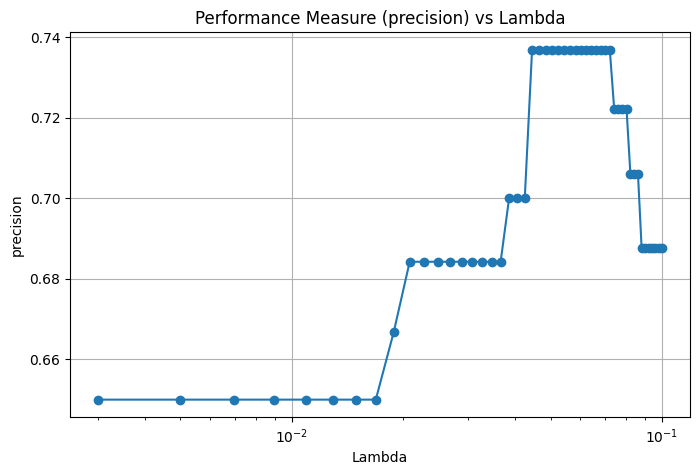

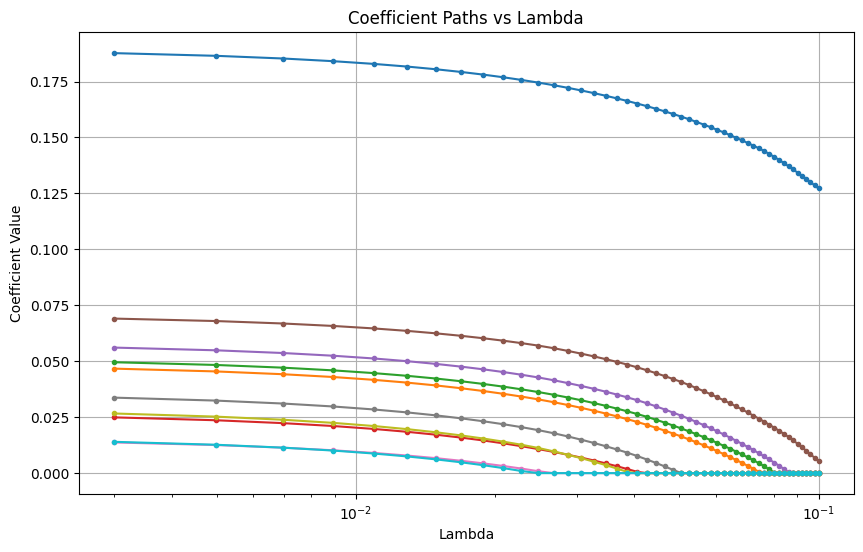

In [8]:
lambdas = np.linspace(0.1, 0.003, 50)  # explicitly 100 lambda values from 0.001 to 0.000001
model_not_weighted = LogRegCCD(lambdas=lambdas)
model_not_weighted.fit(X_train, y_train, False)
model_not_weighted.validate(X_val, y_val)
# print(model.intercept_path_)
# Validate and select best lambda
model_not_weighted.plot(X_val, y_val, measure="precision")
model_not_weighted.plot_coefficients()

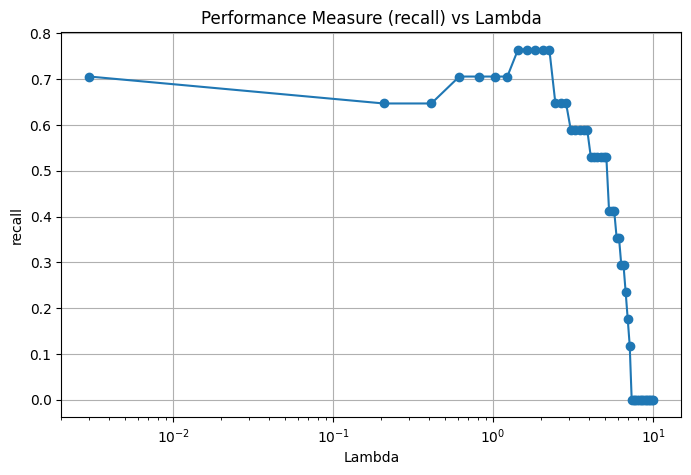

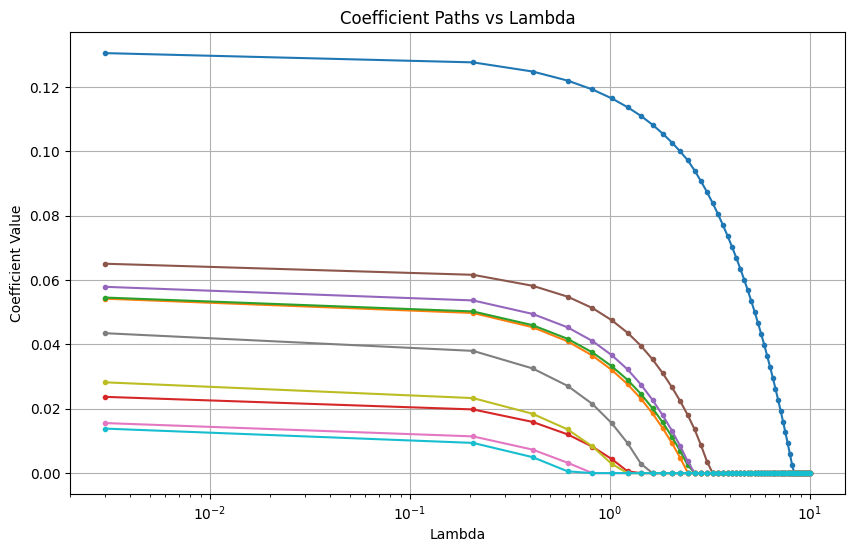

In [12]:
lambdas = np.linspace(10, 0.003, 50)  # explicitly 100 lambda values from 0.001 to 0.000001
model_weighted = LogRegCCD(lambdas=lambdas)
model_weighted.fit(X_train, y_train, True)
model_weighted.validate(X_val, y_val)
# print(model.intercept_path_)
# Validate and select best lambda
model_weighted.plot(X_val, y_val, measure="recall")
model_weighted.plot_coefficients()